In [45]:
import numpy as np
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
data_train = pd.read_csv('data/fashion-mnist_train.csv')
X_full = data_train.iloc[:,1:]
y_full = data_train.iloc[:,:1]
x_train, x_test, y_train, y_test = train_test_split(X_full, y_full, test_size
= 0.3)

In [3]:
x_train = x_train.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
y_train = y_train.values.astype('int')
y_test = y_test.values.astype('int')
print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

Training (42000, 28, 28, 1) 1.0
Testing (18000, 28, 28, 1) 1.0


In [4]:
# reorganize by groups
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [4241, 4277, 4210, 4214, 4184, 4173, 4165, 4200, 4151, 4185]
test groups: [1759, 1723, 1790, 1786, 1816, 1827, 1835, 1800, 1849, 1815]


In [5]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

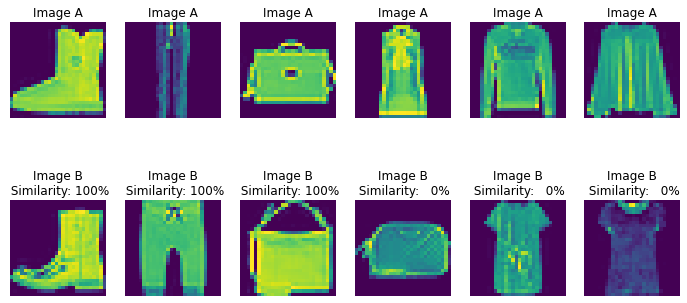

In [6]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
    ax2.axis('off')

In [28]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout

In [8]:
img_in = Input(shape=x_train.shape[1:], name='FeatureNet_ImageInput')
n_layer = img_in
for i in range(2):
    n_layer = Conv2D(8*2**i, kernel_size=(3,3), activation='linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = Conv2D(16*2**i, kernel_size=(3,3), activation='linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = MaxPool2D((2,2))(n_layer)
n_layer = Flatten()(n_layer)
n_layer = Dense(32, activation='linear')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation('relu')(n_layer)
feature_model = Model(inputs=[img_in], outputs=[n_layer], name='FeatureGenerationModel')
feature_model.summary()

Model: "FeatureGenerationModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FeatureNet_ImageInput (Input [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 8)         32        
_________________________________________________________________
activation (Activation)      (None, 26, 26, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 24, 24, 

In [10]:
def Xception(include_top=True,
             weights='imagenet',
             input_tensor=None,
             input_shape=None,
             pooling=None,
             classes=1000,
             **kwargs):
    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=299,
                                      min_size=71,
                                      data_format=backend.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    channel_axis = 1 if backend.image_data_format() == 'channels_first' else -1

    x = layers.Conv2D(32, (3, 3),
                      strides=(2, 2),
                      use_bias=False,
                      name='block1_conv1')(img_input)
    x = layers.BatchNormalization(axis=channel_axis, name='block1_conv1_bn')(x)
    x = layers.Activation('relu', name='block1_conv1_act')(x)
    x = layers.Conv2D(64, (3, 3), use_bias=False, name='block1_conv2')(x)
    x = layers.BatchNormalization(axis=channel_axis, name='block1_conv2_bn')(x)
    x = layers.Activation('relu', name='block1_conv2_act')(x)

    residual = layers.Conv2D(128, (1, 1),
                             strides=(2, 2),
                             padding='same',
                             use_bias=False)(x)
    residual = layers.BatchNormalization(axis=channel_axis)(residual)

    x = layers.SeparableConv2D(128, (3, 3),
                               padding='same',
                               use_bias=False,
                               name='block2_sepconv1')(x)
    x = layers.BatchNormalization(axis=channel_axis, name='block2_sepconv1_bn')(x)
    x = layers.Activation('relu', name='block2_sepconv2_act')(x)
    x = layers.SeparableConv2D(128, (3, 3),
                               padding='same',
                               use_bias=False,
                               name='block2_sepconv2')(x)
    x = layers.BatchNormalization(axis=channel_axis, name='block2_sepconv2_bn')(x)

    x = layers.MaxPooling2D((3, 3),
                            strides=(2, 2),
                            padding='same',
                            name='block2_pool')(x)
    x = layers.add([x, residual])

    residual = layers.Conv2D(256, (1, 1), strides=(2, 2),
                             padding='same', use_bias=False)(x)
    residual = layers.BatchNormalization(axis=channel_axis)(residual)

    x = layers.Activation('relu', name='block3_sepconv1_act')(x)
    x = layers.SeparableConv2D(256, (3, 3),
                               padding='same',
                               use_bias=False,
                               name='block3_sepconv1')(x)
    x = layers.BatchNormalization(axis=channel_axis, name='block3_sepconv1_bn')(x)
    x = layers.Activation('relu', name='block3_sepconv2_act')(x)
    x = layers.SeparableConv2D(256, (3, 3),
                               padding='same',
                               use_bias=False,
                               name='block3_sepconv2')(x)
    x = layers.BatchNormalization(axis=channel_axis, name='block3_sepconv2_bn')(x)

    x = layers.MaxPooling2D((3, 3), strides=(2, 2),
                            padding='same',
                            name='block3_pool')(x)
    x = layers.add([x, residual])

    residual = layers.Conv2D(728, (1, 1),
                             strides=(2, 2),
                             padding='same',
                             use_bias=False)(x)
    residual = layers.BatchNormalization(axis=channel_axis)(residual)

    x = layers.Activation('relu', name='block4_sepconv1_act')(x)
    x = layers.SeparableConv2D(728, (3, 3),
                               padding='same',
                               use_bias=False,
                               name='block4_sepconv1')(x)
    x = layers.BatchNormalization(axis=channel_axis, name='block4_sepconv1_bn')(x)
    x = layers.Activation('relu', name='block4_sepconv2_act')(x)
    x = layers.SeparableConv2D(728, (3, 3),
                               padding='same',
                               use_bias=False,
                               name='block4_sepconv2')(x)
    x = layers.BatchNormalization(axis=channel_axis, name='block4_sepconv2_bn')(x)

    x = layers.MaxPooling2D((3, 3), strides=(2, 2),
                            padding='same',
                            name='block4_pool')(x)
    x = layers.add([x, residual])

    for i in range(8):
        residual = x
        prefix = 'block' + str(i + 5)

        x = layers.Activation('relu', name=prefix + '_sepconv1_act')(x)
        x = layers.SeparableConv2D(728, (3, 3),
                                   padding='same',
                                   use_bias=False,
                                   name=prefix + '_sepconv1')(x)
        x = layers.BatchNormalization(axis=channel_axis,
                                      name=prefix + '_sepconv1_bn')(x)
        x = layers.Activation('relu', name=prefix + '_sepconv2_act')(x)
        x = layers.SeparableConv2D(728, (3, 3),
                                   padding='same',
                                   use_bias=False,
                                   name=prefix + '_sepconv2')(x)
        x = layers.BatchNormalization(axis=channel_axis,
                                      name=prefix + '_sepconv2_bn')(x)
        x = layers.Activation('relu', name=prefix + '_sepconv3_act')(x)
        x = layers.SeparableConv2D(728, (3, 3),
                                   padding='same',
                                   use_bias=False,
                                   name=prefix + '_sepconv3')(x)
        x = layers.BatchNormalization(axis=channel_axis,
                                      name=prefix + '_sepconv3_bn')(x)

        x = layers.add([x, residual])

    residual = layers.Conv2D(1024, (1, 1), strides=(2, 2),
                             padding='same', use_bias=False)(x)
    residual = layers.BatchNormalization(axis=channel_axis)(residual)

    x = layers.Activation('relu', name='block13_sepconv1_act')(x)
    x = layers.SeparableConv2D(728, (3, 3),
                               padding='same',
                               use_bias=False,
                               name='block13_sepconv1')(x)
    x = layers.BatchNormalization(axis=channel_axis, name='block13_sepconv1_bn')(x)
    x = layers.Activation('relu', name='block13_sepconv2_act')(x)
    x = layers.SeparableConv2D(1024, (3, 3),
                               padding='same',
                               use_bias=False,
                               name='block13_sepconv2')(x)
    x = layers.BatchNormalization(axis=channel_axis, name='block13_sepconv2_bn')(x)

    x = layers.MaxPooling2D((3, 3),
                            strides=(2, 2),
                            padding='same',
                            name='block13_pool')(x)
    x = layers.add([x, residual])

    x = layers.SeparableConv2D(1536, (3, 3),
                               padding='same',
                               use_bias=False,
                               name='block14_sepconv1')(x)
    x = layers.BatchNormalization(axis=channel_axis, name='block14_sepconv1_bn')(x)
    x = layers.Activation('relu', name='block14_sepconv1_act')(x)

    x = layers.SeparableConv2D(2048, (3, 3),
                               padding='same',
                               use_bias=False,
                               name='block14_sepconv2')(x)
    x = layers.BatchNormalization(axis=channel_axis, name='block14_sepconv2_bn')(x)
    x = layers.Activation('relu', name='block14_sepconv2_act')(x)

    if include_top:
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = layers.Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = models.Model(inputs, x, name='xception')

    return model

In [48]:
feature_model = Xception(
    include_top=True,
    weights=None,
    input_tensor=Input((25, 25, 1), name='image_input'),
    input_shape=None,
    pooling=None,
    classes=np.unique(y_train).shape[0],
    classifier_activation="softmax",
)
feature_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 12, 12, 32)   288         image_input[0][0]                
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 12, 12, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 12, 12, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [11]:
from keras.layers import concatenate
img_a_in = Input(shape = x_train.shape[1:], name='ImageA_Input')
img_b_in = Input(shape = x_train.shape[1:], name='ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = concatenate([img_a_feat, img_b_feat], name='merge_features')
combined_features = Dense(16, activation='linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation='linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation ='sigmoid')(combined_features)
similarity_model = Model(inputs=[img_a_in, img_b_in], outputs=[combined_features], name='Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ImageA_Input (InputLayer)       [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
ImageB_Input (InputLayer)       [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
xception (Functional)           (None, 10)           20881394    ImageA_Input[0][0]               
                                                                 ImageB_Input[0][0]               
__________________________________________________________________________________________________
merge_features (Concatenate)    (None, 20)           0           xception[0][0]    

In [12]:
# setup the optimization process
similarity_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae'])

In [13]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig

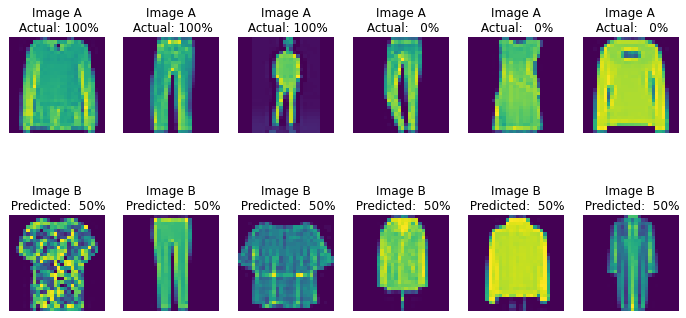

In [14]:
# a completely untrained model
_ = show_model_output()

In [15]:
# make a generator out of the data
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim

In [16]:
# we want a constant validation group to have a frame of reference for model performance
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 128)
loss_history = similarity_model.fit_generator(siam_gen(train_groups),
                                              steps_per_epoch=100,
                                              validation_data=([valid_a, valid_b], valid_sim),
                                              epochs = 10,
                                              verbose = True)

C:\Users\1\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
100/100 [==============================] - 217s 2s/step - loss: 0.6929 - mae: 0.4952 - val_loss: 0.6932 - val_mae: 0.5000
Epoch 2/10
100/100 [==============================] - 194s 2s/step - loss: 0.6119 - mae: 0.4443 - val_loss: 0.6932 - val_mae: 0.5000
Epoch 3/10
100/100 [==============================] - 195s 2s/step - loss: 0.5598 - mae: 0.4104 - val_loss: 0.6333 - val_mae: 0.4623
Epoch 4/10
100/100 [==============================] - 194s 2s/step - loss: 0.5463 - mae: 0.3944 - val_loss: 0.5552 - val_mae: 0.4051
Epoch 5/10
100/100 [==============================] - 196s 2s/step - loss: 0.5223 - mae: 0.3764 - val_loss: 0.5326 - val_mae: 0.3805
Epoch 6/10
100/100 [==============================] - 191s 2s/step - loss: 0.5352 - mae: 0.3760 - val_loss: 0.5287 - val_mae: 0.3695
Epoch 7/10
100/100 [==============================] - 192s 2s/step - loss: 0.5012 - mae: 0.3530 - val_loss: 0.6922 - val_mae: 0.4990
Epoch 8/10
100/100 [==============================] - 194s 2s/step - 

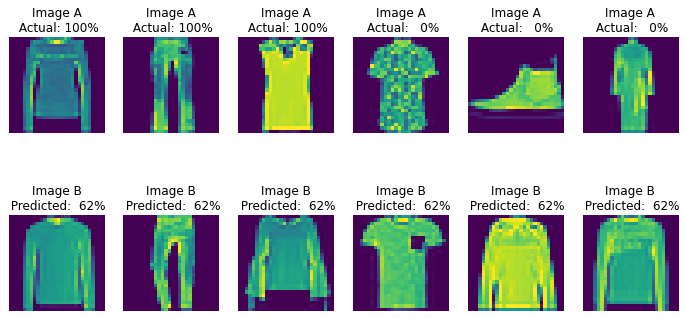

In [17]:
_ = show_model_output()

In [18]:
t_shirt_vec = np.stack([train_groups[0][0]]*x_test.shape[0],0)
t_shirt_score = similarity_model.predict([t_shirt_vec, x_test], verbose=True, batch_size=128)
ankle_boot_vec = np.stack([train_groups[-1][0]]*x_test.shape[0],0)
ankle_boot_score = similarity_model.predict([ankle_boot_vec, x_test], verbose=True, batch_size=128)

141/141 [==============================] - 66s 465ms/step


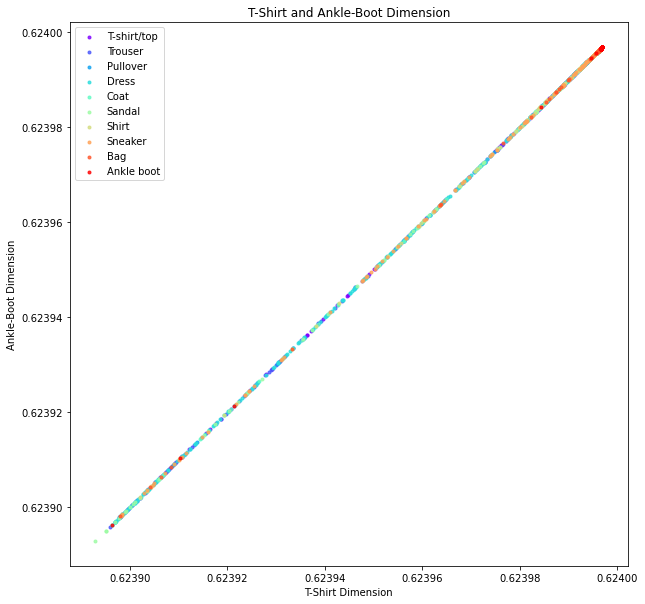

In [19]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(t_shirt_score[np.where(y_test == c_group), 0],
                ankle_boot_score[np.where(y_test == c_group), 0],
                marker='.',
                color=c_color,
                linewidth=1,
                alpha=0.8,
                label=c_label)
plt.xlabel('T-Shirt Dimension')
plt.ylabel('Ankle-Boot Dimension')
plt.title('T-Shirt and Ankle-Boot Dimension')
plt.legend(loc='best')
plt.savefig('tshirt-boot-dist.png')
plt.show(block=False)

In [20]:
x_test_features = feature_model.predict(x_test, verbose=True, batch_size=128)

141/141 [==============================] - 36s 252ms/step


In [21]:
%%time
from sklearn.manifold import TSNE
tsne_obj = TSNE(n_components=2,
                init='pca',
                random_state=101,
                method='barnes_hut',
                n_iter=500,
                verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

C:\Users\1\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18000 samples in 0.067s...
[t-SNE] Computed neighbors for 18000 samples in 0.990s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18000
[t-SNE] Computed conditional probabilities for sample 2000 / 18000
[t-SNE] Computed conditional probabilities for sample 3000 / 18000
[t-SNE] Computed conditional probabilities for sample 4000 / 18000
[t-SNE] Computed conditional probabilities for sample 5000 / 18000
[t-SNE] Computed conditional probabilities for sample 6000 / 18000
[t-SNE] Computed conditional probabilities for sample 7000 / 18000
[t-SNE] Computed conditional probabilities for sample 8000 / 18000
[t-SNE] Computed conditional probabilities for sample 9000 / 18000
[t-SNE] Computed conditional probabilities for sample 10000 / 18000
[t-SNE] Computed conditional probabilities for sample 11000 / 18000
[t-SNE] Computed conditional probabilities for sample 12000 / 18000
[t-SNE] Computed conditional probabilities for sam

C:\Users\1\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 101.8360748, gradient norm = 0.0137956 (50 iterations in 35.200s)
[t-SNE] Iteration 100: error = 77.8419113, gradient norm = 0.0094235 (50 iterations in 8.514s)
[t-SNE] Iteration 150: error = 70.6477966, gradient norm = 0.0027197 (50 iterations in 6.888s)
[t-SNE] Iteration 200: error = 66.9721985, gradient norm = 0.0020769 (50 iterations in 6.875s)
[t-SNE] Iteration 250: error = 64.6287003, gradient norm = 0.0016880 (50 iterations in 6.610s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.628700
[t-SNE] Iteration 300: error = 2.4695547, gradient norm = 0.0011235 (50 iterations in 6.892s)
[t-SNE] Iteration 350: error = 1.9064237, gradient norm = 0.0006763 (50 iterations in 7.204s)
[t-SNE] Iteration 400: error = 1.5266287, gradient norm = 0.0004425 (50 iterations in 7.001s)
[t-SNE] Iteration 450: error = 1.2778258, gradient norm = 0.0003136 (50 iterations in 7.046s)
[t-SNE] Iteration 500: error = 1.1074336, gradient norm = 0.0002355 (5

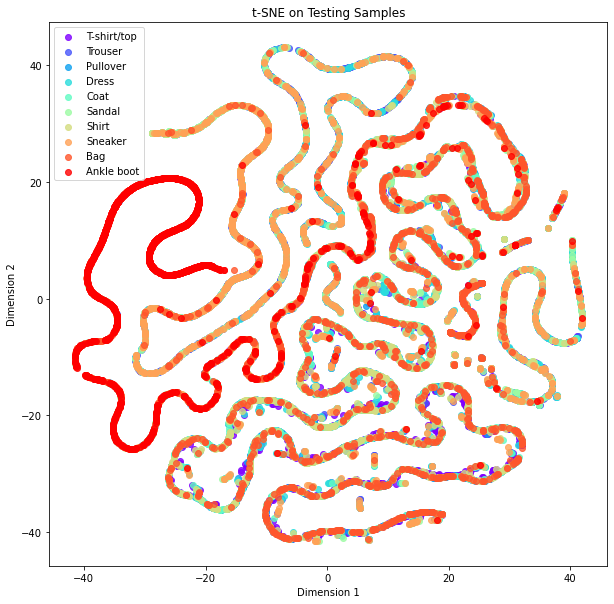

In [22]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
                tsne_features[np.where(y_test == c_group), 1],
                marker='o',
                color=c_color,
                linewidth=1,
                alpha=0.8,
                label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)